<h1>بخش اول : پیش پردازش</h1>
<p dir="rtl">
  تمامی مراحل پیش پردازش در مرحله قبلی انجام شده است
</p>

ما در تحلیلی که در انتهای پیش پردازش انجام دادیم متوجه شدیم برای پیدا کردن مقادیر گمشده راه حل خیلی خوبی وجود نداره
برای همین در این قسمت تصمیم گرفتیم در نهایت داده های گم شده رو حذف کنیم و تعداد زیادی هم حذف نمیشود با توجه به اینکه کلا ۱۰۰هزار داده گمشده در مساحت بنا وجود داره

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
irCitiesDf = pd.read_csv("drive/MyDrive/AiPractice-g6/divar__iran_city_classification.csv")

citiesLe = LabelEncoder()
irCitiesDf = irCitiesDf.rename(columns={
    'دسته‌بندی' : 'city_type',
    'نام شهر' : 'city_name'
})
irCitiesDf["city_type"] = citiesLe.fit_transform(irCitiesDf["city_type"])

In [ ]:
mainDf = pd.read_csv("drive/MyDrive/AiPractice-g6/divar__main.csv")

<ipython-input-4-3fe2c69301a6>:1: DtypeWarning: Columns (11,27,29,53) have mixed types. Specify dtype option on import or set low_memory=False.
  mainDf = pd.read_csv("drive/MyDrive/AiPractice-g6/divar__main.csv")


In [ ]:
#---------------add a new column about being big city or not---------------
#---------------Big cities---------------
big_cities_name = []
for j in irCitiesDf[irCitiesDf['city_type']== 1]['city_name'].values:
    big_cities_name.append(j)

mainDf['big_city'] = mainDf['city_slug'].isin(big_cities_name).astype(int)

# #---------------change type of the created_at_month column---------------
mainDf['created_at_month'] = pd.to_datetime(mainDf['created_at_month'])

<h2>سوال اول</h2>


با توجه به رشد مهاجرت افراد از شهر‌های کوچکتر به کلان‌شهر‌ها و تراکم جمعیت در این نواحی، تصور می‌شود که میانگین مساحت خانه‌های مسکونی در کلان‌شهرها نسبت به شهر‌های کوچک و روستاها کمتر است. آیا مجموعه داده‌ این فرضیه را پشتیبانی می‌کند؟(برای دسته‌بندی شهرها به کلان‌شهر و شهر کوچک می‌توانید از این مجموعه داده استفاده کنید.)

In [ ]:
mainDf.describe()["building_size"]

,building_size
count,9.803940e+05
mean,4.440648e+03
min,1.000000e+00
25%,7.500000e+01
50%,1.030000e+02
75%,1.650000e+02
max,1.000000e+07
std,1.367118e+05


بررسی ساختار توزیع مساحت زیربنا

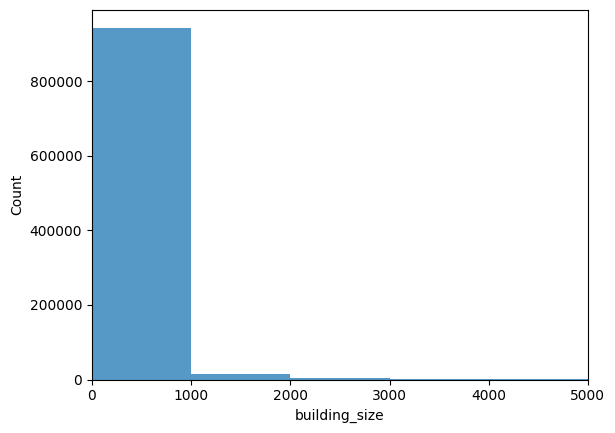

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(mainDf["building_size"], bins=10000)
plt.xlim(0, 5000)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

low, high = mainDf["building_size"].quantile([0.01, 0.99])
mainDf_filtered = mainDf[(mainDf["building_size"] >= low) & (mainDf["building_size"] <= high)]

mainDf_filtered.describe()["building_size"] #=> انحراف معیار بسیار بالا بود پس میایم بین صدک ۱ و ۳ میاریم

# sns.histplot(mainDf_filtered["building_size"], bins=10000)
# plt.xlim(0, 5000)
# plt.show()

Q1 = mainDf_filtered["building_size"].quantile(0.25)
Q3 = mainDf_filtered["building_size"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mainDf_filtered = mainDf_filtered[
    (mainDf_filtered["building_size"] >= lower_bound) &
    (mainDf_filtered["building_size"] <= upper_bound)
]

cleanedDf = mainDf_filtered.copy()
cleanedDf = mainDf_filtered.drop_duplicates()

In [ ]:
cleanedDf.describe()["building_size"]

,building_size
count,854786.000000
mean,108.595018
min,12.000000
25%,70.000000
50%,99.000000
75%,135.000000
max,290.000000
std,54.560541


In [ ]:
# #---------------fill neighborhood_slug nulls for big_city == 0---------------
# change_neighborhood = mainDf['neighborhood_slug'].isnull() & (mainDf['big_city'] == 0)
# mainDf.loc[change_neighborhood, 'neighborhood_slug'] = mainDf.loc[change_neighborhood, 'city_slug']


In [ ]:
# mainDf[mainDf['big_city']==1]['neighborhood_slug'].value_counts()

In [ ]:
# @title Pre Proceesing
# STEP 1-2 : Missing Values

# در ادامه تصمیمات خودم برای داده های نال دیتاست رو تو کامنت ها مینویسم
#------- Unnamed هنوز کاری بهش ندارم ولی چون نام نداره بنظرم کار خاصی باهاش نداریم میتونیم پاکش کنیم
cleanedDf = cleanedDf.drop(["Unnamed: 0"] , axis=1)

#------- cat3_slug (1 NAN) : Row Deletion
cleanedDf = cleanedDf[~cleanedDf["cat3_slug"].isna()]

#------- city_slug (2 NAN) : Row Deletion
cleanedDf = cleanedDf[~cleanedDf["city_slug"].isna()]

cleanedDf = pd.merge(
    cleanedDf,
    irCitiesDf,
    left_on='city_slug',
    right_on='city_name',
    how='left'
)

In [ ]:
cleanedDf["cat3_slug"].unique()

array(['apartment-sell', 'apartment-rent', 'office-rent', 'shop-sell',
       'house-villa-sell', 'house-villa-rent', 'plot-old', 'shop-rent',
       'office-sell', 'industry-agriculture-business-sell', 'villa',
       'suite-apartment', 'industry-agriculture-business-rent',
       'workspace', 'presell', 'partnership'], dtype=object)

In [ ]:
cleanedDf[cleanedDf["cat3_slug"] == "house-villa-sell"]["title"].head()

,title
16,ویلای خوش نقشه
19,ویلا باغ۶۰۰م سنددار شهرکی ٪زیر قیمت٪مشجر جاده ...
20,فروش خانه دو طبقه کمربندی غربی توحید
28,ویلا دوبلکس باغی فول مبله جنگلی/سند فر.وش فو.ری
35,فروش مهندسی ساز شرف اباد


In [ ]:
from scipy.stats import ttest_ind

residential_categories = [
    "apartment-sell",
    "apartment-rent",
    # "house-villa-sell", مشکوک
    # "house-villa-rent", مشکوک
    "suite-apartment",
    # "presell" یکسری جا ها پیش فروش برای زمینه
]

residentialDf = cleanedDf[cleanedDf["cat3_slug"].isin(residential_categories)].copy()

megacity = residentialDf[residentialDf["big_city"] == 1]["building_size"]
smalltown = residentialDf[residentialDf["big_city"] == 0]["building_size"]

t_stat, p_val = ttest_ind(megacity, smalltown, equal_var=False)
print(f"T-stat: {t_stat}, P-value: {p_val}")


T-stat: 65.70626849610053, P-value: 0.0


<h2>نتیجه سوال اول</h2>

بر اساس جوابی که گرفتیم میتونیم استناد کنیم که بله
با توجه به اینکه

p-value

کمتر از 0.05 میباشد

> مساحت خانه هایی که در کلان شهر هستند از شهر و روستا کمتر میباشد

و این نتیجه نشان دهنده اختلاف قابل توجه میانگین خانه ها  در کلان شهر و غیرکلانشهر میباشد


<h2>سوال دوم</h2>


معمولا این جمله را می‌شنویم که «قدیما خونه‌ها دلبازتر بود!» برای بررسی این فرضیه، آیا میانگین مساحت خانه‌های قدیمی‌ساخت نسبت به خانه‌های جدید ساخت بیشتر است؟( خانه‌های قدیمی‌ساخت را خانه‌هایی در نظر بگیرید که قبل از سال ۹۶ ساخته شده‌اند.)

In [ ]:
cleanedDf["construction_year"].unique()

array(['۱۳۸۴', '۱۴۰۱', '۱۴۰۰', '۱۴۰۳', '۱۳۸۹', '۱۳۹۵', '۱۳۹۳', '۱۳۹۶',
       '۱۳۸۷', '۱۳۸۵', '۱۳۹۰', '۱۳۹۸', '۱۴۰۲', '۱۳۸۸', 'قبل از ۱۳۷۰',
       '۱۳۹۲', '۱۳۸۳', '۱۳۹۴', '۱۳۹۱', '۱۳۸۰', nan, '۱۳۷۸', '۱۳۷۵',
       '۱۳۹۹', '۱۳۸۲', '۱۳۹۷', '۱۳۸۶', '۱۳۷۹', '۱۳۷۲', '۱۳۷۴', '۱۳۷۶',
       '۱۳۷۷', '۱۳۷۱', '۱۳۸۱', '۱۳۷۳'], dtype=object)

In [ ]:
def numbers_persian_to_english(persian_number):
    persian_numbers = '۰۱۲۳۴۵۶۷۸۹'
    english_numbers = '0123456789'

    transform = str.maketrans(persian_numbers, english_numbers)

    return str(persian_number).translate(transform)

In [ ]:
cleanedDf['construction_year'] = cleanedDf['construction_year'].str.replace('قبل از ۱۳۷۰', '۱۳۶۹', regex=False)
cleanedDf['construction_year'] = cleanedDf['construction_year'].apply(numbers_persian_to_english)

cleanedDf = cleanedDf[cleanedDf['construction_year'].notna()]  # حذف NaN
cleanedDf = cleanedDf[cleanedDf['construction_year'].str.isnumeric()]  # فقط مقادیر عددی

cleanedDf['construction_year'] = cleanedDf['construction_year'].astype(int)
cleanedDf['is_old'] = cleanedDf['construction_year'].apply(lambda x: 1 if x < 1396 else 0)


In [ ]:
old_houses = cleanedDf[cleanedDf['is_old'] == 0]['building_size']
new_houses = cleanedDf[cleanedDf['is_old'] == 1]['building_size']

print("Old Houses Mean:", old_houses.mean())
print("New Houses Mean:", new_houses.mean())

from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(old_houses, new_houses, equal_var=False)

print(f"T-stat: {t_stat}, P-value: {p_val}")


Old Houses Mean: 110.75866465036019
New Houses Mean: 94.0418206364513
T-stat: 150.9515113755225, P-value: 0.0


<h2>نتیجه سوال دوم</h2>

با توجه به دیتاستی که داریم



1.   110 داده از خانه های قدیمی
2.   داده از خانه های جدید 94

ما یک توزیع متعادل از لحاظ تعدادی بین خانه های جدید و قدیمی داریم

<h2>سوال سوم</h2>


داشتن سند تجاری (یا هر نوع سند ملکی) در املاک به این معنی است که سند مالکیت معتبر، رسمی و قانونی برای ملک تجاری دارید. این سند نشان می‌دهد که شما صاحب قانونی ملک تجاری هستید و می‌توانید از حقوق مالکیت آن استفاده کنید. بررسی کنید که آیا داشتن سند تجاری(has_business_deed) بر میانگین قیمت فروش ملک تجاری تاثیر معناداری دارد؟

In [ ]:
#---------------has business_deed---------------
has_business_deed_true = cleanedDf['description'].str.contains(r'\bسند تجاری\b', regex=True, na=False) & (cleanedDf['has_business_deed'].isnull())
cleanedDf.loc[has_business_deed_true, 'has_business_deed'] = True

In [ ]:
# commercial_df.info()

In [ ]:
from scipy.stats import ttest_ind

commercial_types = ['shop-sell', 'office-sell', 'industry-agriculture-business-sell']
commercial_df = cleanedDf[cleanedDf['cat3_slug'].isin(commercial_types)]
commercial_df = commercial_df.dropna(subset=['price_value', 'has_business_deed'])

with_deed = commercial_df[commercial_df['has_business_deed'] == 1]['price_value']
without_deed = commercial_df[commercial_df['has_business_deed'] == 0]['price_value']

print("With Deed Mean Price:", with_deed.mean())
print("Without Deed Mean Price:", without_deed.mean())


t_stat, p_val = ttest_ind(with_deed, without_deed, equal_var=False)
print(f"T-stat: {t_stat}, P-value: {p_val}")

With Deed Mean Price: 27772282593.82166
Without Deed Mean Price: 24174463163.682148
T-stat: 0.28939050311737824, P-value: 0.7722862129786656


<h2>نتیجه سوال سوم</h2>

نتیجه مقدار
p-value
زیاد تاثیری نداره

<h2>سوال چهارم</h2>

در دسته‌بندی امکانات موجود در آگهی‌ها می‌توانیم آنها را به دو دسته‌ی امکانات لاکچری(استخر، باربیکیو، سونا، جکوزی) و امکانات غیر لاکچری تقسیم کنیم. فرضیه‌ی ما این است که میانگین مبلغ قیمت برای وجود ویژگی‌های لاکچری افزایش چشم‌گیری دارد. اما آیا این میانگین برای وجود امکانات غیرلاکچری نیز تفاوت معناداری دارد؟

In [ ]:
df = cleanedDf.copy()

df = df[df['price_value'].notna()]
#---------------fill sauna_true---------------
sauna_true = df['description'].str.contains(r'\bسونا\b', regex=True, na=False) & (df['has_sauna'].isnull())
df.loc[sauna_true, 'has_sauna'] = True

#---------------fill jacuzzi_true---------------
jacuzzi_true = df['description'].str.contains(r'\bجکوزی\b', regex=True, na=False) & (df['has_jacuzzi'].isnull())
df.loc[jacuzzi_true, 'has_jacuzzi'] = True

#---------------fill pool_true---------------
pool_true = df['description'].str.contains(r'\bاستخر\b', regex=True, na=False) & (df['has_pool'].isnull())
df.loc[pool_true, 'has_pool'] = True

#---------------fill barbecue_true---------------
barbecue_true = df['description'].str.contains(r'\bباربیکیو\b', regex=True, na=False) & (df['has_barbecue'].isnull())
df.loc[barbecue_true, 'has_barbecue'] = True

#---------------fill security_guard_true---------------
security_guard_true = ((df['description'].str.contains(r'\bنگهبان\b', regex=True, na=False)) | (df['description'].str.contains(r'\bنگهبانی\b', regex=True, na=False)) | (df['description'].str.contains(r'\bلابی من\b', regex=True, na=False))) & (df['has_security_guard'].isnull())
df.loc[security_guard_true, 'has_security_guard'] = True

def fill_null(df, columns_name, value):
    for i in columns_name:
        df[i].fillna(value, inplace = True)

columns_False = ['has_sauna','has_jacuzzi','has_pool','has_barbecue',
                 'has_security_guard','has_business_deed',
                 'has_balcony','has_elevator','is_rebuilt',
                 'has_parking','has_warehouse','has_gas',
                 'has_electricity', 'has_water']
fill_null(df, columns_False, False)

df['luxury'] = df[['has_sauna', 'has_jacuzzi', 'has_pool', 'has_security_guard', 'has_barbecue']].sum(axis=1)


<ipython-input-44-a40df5c31139>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(value, inplace = True)
<ipython-input-44-a40df5c31139>:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i].fillna(value, inplace = True)


In [ ]:
df.shape

(426785, 65)

In [ ]:
from scipy.stats import ttest_ind


with_luxury = df[df["luxury"] == 1]["price_value"]
without_luxury = df[df["luxury"] == 0]["price_value"]

t_stat, p_val = ttest_ind(with_luxury, without_luxury, equal_var=False)

print("With Luxury Mean Price:", with_luxury.mean())
print("Without Luxury Mean Price:", without_luxury.mean())
print(f"T-stat: {t_stat}, P-value: {p_val}")

With Luxury Mean Price: 14759986137.269218
Without Luxury Mean Price: 13736755134.187271
T-stat: 0.4148706653760336, P-value: 0.6782391714454936


<h2>نتیجه سوال چهارم</h2>

این تفاوت از نظر آماری معنادار نیست.
یعنی با اینکه قیمت خانه‌های دارای امکانات لاکچری به‌طور میانگین کمی بیشتره، اما این اختلاف احتمالاً تصادفیه و نمی‌تونیم بگیم به‌صورت معنادار قیمت‌ها بیشتر می‌شن.
